In [38]:
# Modify the API script to resample data to daily instead of hourly
import requests
import pandas as pd
import datetime as dt

# # Define API details
# DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'
# api_key = '56642815-d535-418b-bda2-30a8a8ef4999'

# # Specify the desired start and end time
# start_time = pd.Timestamp(2002, 1, 1)
# end_time = pd.Timestamp(2023, 12, 31)
# datetime_str = start_time.tz_localize('UTC').isoformat() + '/' + end_time.tz_localize('UTC').isoformat()

# # Station ID
# stationIds = ['06102']

# # List of required parameters
# parameterIds = [
#     "temp_min_past1h", "temp_max_past1h", "temp_mean_past1h",
#     "temp_grass_mean_past1h", "temp_soil_min_past1h", "temp_soil_max_past1h", "temp_soil_mean_past1h",
#     "humidity_past1h", "pressure", "wind_dir_past1h", "wind_min_past1h",
#     "wind_gust_always_past1h", "wind_speed_past1h", "precip_past1h", "precip_dur_past1h",
#     "radia_glob_past1h", "sun_last1h_glob"
# ]

# # Fetch data for all parameters
# dfs = []
# for station in stationIds:
#     for parameter in parameterIds:
#         # Define API query parameters
#         params = {
#             'api-key': api_key,
#             'datetime': datetime_str,
#             'stationId': station,
#             'parameterId': parameter,
#             'limit': '300000',  # Max limit
#         }

#         # Send GET request
#         response = requests.get(DMI_URL, params=params)

#         # Check response status
#         if response.status_code == 200:
#             json_data = response.json()

#             # Extract data into DataFrame
#             if 'features' in json_data and json_data['features']:
#                 dfi = pd.json_normalize(json_data['features'])
#                 dfi['time'] = pd.to_datetime(dfi['properties.observed'])
#                 dfi = dfi[['time', 'properties.value', 'properties.stationId', 'properties.parameterId']]
#                 dfi.columns = [c.replace('properties.', '') for c in dfi.columns]
#                 dfi = dfi[~dfi.duplicated()]  # Remove duplicates
#                 dfi = dfi.set_index(['parameterId', 'stationId', 'time'])
#                 dfi = dfi['value'].unstack(['stationId', 'parameterId'])
#                 dfs.append(dfi)

# # Combine all data into a single DataFrame
# if dfs:
#     df = pd.concat(dfs, axis='columns').sort_index()

#     # Flatten MultiIndex by removing station ID level and keeping only parameter names
#     df.columns = df.columns.get_level_values(1)

#     # Define aggregation methods for daily resampling
#     aggregation_methods = {
#         "temp_min_past1h": "min",  # Minimum temperature of the day
#         "temp_max_past1h": "max",  # Maximum temperature of the day
#         "temp_mean_past1h": "mean",  # Daily mean temperature
#         "temp_grass_mean_past1h": "mean",  # Mean grass temperature
#         "temp_soil_min_past1h": "min",  # Minimum soil temperature
#         "temp_soil_max_past1h": "max",  # Maximum soil temperature
#         "temp_soil_mean_past1h": "mean",  # Mean soil temperature
#         "humidity_past1h": "mean",  # Average humidity of the day
#         "pressure": "mean",  # Mean atmospheric pressure
#         "wind_dir_past1h": "mean",  # Average wind direction
#         "wind_min_past1h": "min",  # Minimum wind speed
#         "wind_gust_always_past1h": "max",  # Maximum wind gust
#         "wind_speed_past1h": "mean",  # Mean wind speed
#         "precip_past1h": "sum",  # Total daily precipitation
#         "precip_dur_past1h": "sum",  # Total minutes of precipitation
#         "radia_glob_past1h": "sum",  # Total daily global radiation
#         "sun_last1h_glob": "sum",  # Total sunshine duration per day
#     }

#     # Resample the DataFrame to daily using defined aggregation rules
#     df_daily = df.resample("D").agg(aggregation_methods)

#     # Save as CSV
#     df_daily.to_csv("dmi_weather_data_daily.csv")

# else:
#     print("No data retrieved. Check API response and station/parameter configuration.")

df_daily = pd.read_csv("../Data loading and handling/Cleaned data etc./dmi_weather_data_daily.csv", header=0, parse_dates=["time"], index_col="time")

In [39]:
df_daily.tail() # Show first rows

,temp_min_past1h,temp_max_past1h,temp_mean_past1h,temp_grass_mean_past1h,temp_soil_min_past1h,temp_soil_max_past1h,temp_soil_mean_past1h,humidity_past1h,pressure,wind_dir_past1h,wind_min_past1h,wind_gust_always_past1h,wind_speed_past1h,precip_past1h,precip_dur_past1h,radia_glob_past1h,sun_last1h_glob
time,,,,,,,,,,,,,,,,,
2023-12-20 00:00:00+00:00,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,995.043373,252.000000,NaN,12.2,2.541667,0.4,4.0,349.0,111.0
2023-12-21 00:00:00+00:00,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,975.337324,254.666667,0.7,22.5,5.329167,19.9,159.0,270.0,29.5
2023-12-22 00:00:00+00:00,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,983.997222,293.416667,0.0,19.1,5.020833,0.6,3.0,749.0,294.5
2023-12-23 00:00:00+00:00,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,993.885417,264.000000,NaN,10.5,2.379167,0.8,4.0,589.0,247.0
2023-12-24 00:00:00+00:00,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,992.207273,136.500000,NaN,6.6,1.500000,5.0,38.0,9.0,0.0


In [40]:
# Check for missing values
missing_values = df_daily.isnull().sum()
print("Missing Data Count:\n", missing_values[missing_values > 0])

Missing Data Count:
 temp_min_past1h             150
temp_max_past1h             150
temp_mean_past1h            150
temp_grass_mean_past1h      138
temp_soil_min_past1h        138
temp_soil_max_past1h        138
temp_soil_mean_past1h       138
humidity_past1h             160
pressure                   5931
wind_dir_past1h             143
wind_min_past1h            6245
wind_gust_always_past1h     758
wind_speed_past1h           143
dtype: int64


In [41]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Assume df_daily is your DataFrame with a 'pressure' column (in hPa)
# # If you haven't loaded it yet, you can load it with:
# # df_daily = pd.read_csv("dmi_weather_data_daily.csv", parse_dates=['time'], index_col='time')

# # --- 1. Descriptive Statistics ---
# print("Pressure Descriptive Statistics:")
# print(df_daily['pressure'].describe())

# # Calculate the coefficient of variation (CV) if needed.
# cv = df_daily['pressure'].std() / df_daily['pressure'].mean()
# print(f"Coefficient of Variation: {cv:.2f}")

# # --- 2. Time Series Plot ---
# plt.figure(figsize=(12, 6))
# plt.plot(df_daily.index, df_daily['pressure'], marker='o', linestyle='-', label='Pressure (hPa)')
# plt.xlabel("Date")
# plt.ylabel("Pressure (hPa)")
# plt.title("Daily Pressure Data Over Time")
# plt.legend()
# plt.show()

# # --- 3. Histogram ---
# plt.figure(figsize=(12, 6))
# plt.hist(df_daily['pressure'].dropna(), bins=30, edgecolor='k', alpha=0.7)
# plt.xlabel("Pressure (hPa)")
# plt.ylabel("Frequency")
# plt.title("Histogram of Pressure Data")
# plt.show()

# # --- 4. Boxplot ---
# plt.figure(figsize=(6, 8))
# plt.boxplot(df_daily['pressure'].dropna(), vert=True, patch_artist=True)
# plt.ylabel("Pressure (hPa)")
# plt.title("Boxplot of Pressure Data")
# plt.show()

# # --- 5. Rolling Standard Deviation ---
# # Calculate a 30-day rolling standard deviation to assess variability over time.
# rolling_std = df_daily['pressure'].rolling(window=30).std()

# plt.figure(figsize=(12, 6))
# plt.plot(df_daily.index, rolling_std, label="30-day Rolling Std (hPa)")
# plt.xlabel("Date")
# plt.ylabel("Standard Deviation (hPa)")
# plt.title("Rolling Standard Deviation of Pressure Data")
# plt.legend()
# plt.show()

In [42]:
df_daily.count()

temp_min_past1h            7878
temp_max_past1h            7878
temp_mean_past1h           7878
temp_grass_mean_past1h     7890
temp_soil_min_past1h       7890
temp_soil_max_past1h       7890
temp_soil_mean_past1h      7890
humidity_past1h            7868
pressure                   2097
wind_dir_past1h            7885
wind_min_past1h            1783
wind_gust_always_past1h    7270
wind_speed_past1h          7885
precip_past1h              8028
precip_dur_past1h          8028
radia_glob_past1h          8028
sun_last1h_glob            8028
dtype: int64

In [43]:
# Define threshold for missing data (e.g., remove columns with >50% missing)
missing_threshold = 0.50  # 50%

# Calculate missing data percentage
missing_percent = df_daily.isnull().mean()

# Remove columns with too much missing data
columns_to_drop = missing_percent[missing_percent > missing_threshold].index
df_cleaned = df_daily.drop(columns=columns_to_drop)

print(f"Removed columns due to excessive missing data: {list(columns_to_drop)}")

Removed columns due to excessive missing data: ['pressure', 'wind_min_past1h']


In [44]:
df_cleaned.head() # Show first rows

,temp_min_past1h,temp_max_past1h,temp_mean_past1h,temp_grass_mean_past1h,temp_soil_min_past1h,temp_soil_max_past1h,temp_soil_mean_past1h,humidity_past1h,wind_dir_past1h,wind_gust_always_past1h,wind_speed_past1h,precip_past1h,precip_dur_past1h,radia_glob_past1h,sun_last1h_glob
time,,,,,,,,,,,,,,,
2002-01-01 00:00:00+00:00,-9.3,6.4,1.250000,-0.062500,-0.2,0.1,0.037500,88.708333,281.666667,NaN,6.995833,2.2,34.0,271.0,0.0
2002-01-02 00:00:00+00:00,-6.3,6.4,-0.837500,-1.970833,-0.1,0.0,-0.033333,77.583333,110.208333,NaN,2.695833,0.0,0.0,805.0,328.0
2002-01-03 00:00:00+00:00,-7.6,-1.0,-5.166667,-6.937500,-0.2,0.0,-0.100000,87.458333,158.625000,NaN,1.195833,0.0,0.0,739.0,278.5
2002-01-04 00:00:00+00:00,-9.3,-1.3,-6.025000,-7.950000,-0.7,-0.2,-0.333333,80.916667,221.708333,NaN,0.987500,0.0,0.0,876.0,355.0
2002-01-05 00:00:00+00:00,-10.6,3.7,-3.466667,-4.337500,-1.1,-0.4,-0.754167,92.458333,239.750000,NaN,1.854167,0.1,1.0,659.0,268.5


In [45]:
# Step 1: Identify missing values before processing
missing_before = df_cleaned.isnull().sum()
print(f"Missing values before processing:\n{missing_before[missing_before > 0]}\n")

# Step 2: Apply linear interpolation for gaps up to 12 hours
df_cleaned = df_cleaned.interpolate(method='linear', limit=12, limit_direction='both')

# Step 3: Add helper columns for seasonal mean imputation
df_cleaned["hour"] = df_cleaned.index.hour
df_cleaned["dayofyear"] = df_cleaned.index.dayofyear
df_cleaned["month"] = df_cleaned.index.month
df_cleaned["day"] = df_cleaned.index.day
df_cleaned["year"] = df_cleaned.index.year  # Keep track of leap years


# Step 5: Fill remaining missing values using seasonal means, handling leap years properly
df_cleaned = df_cleaned.groupby(["month", "day", "hour"]).transform(lambda x: x.fillna(x.mean()))

# Step 6: Remove helper columns after filling
df_cleaned.drop(columns=["hour", "dayofyear", "month", "day", "year"], errors="ignore", inplace=True)

# Step 7: Save the cleaned dataset to a new CSV file
df_cleaned.to_csv("dmi_weather_data_cleaned.csv")

# Step 8: Identify missing values after processing
missing_after = df_cleaned.isnull().sum()
print(f"Missing values after processing:\n{missing_after[missing_after > 0]}")
print("\nData cleaning complete!")

df_cleaned.head() # Show first rows

Missing values before processing:
temp_min_past1h            150
temp_max_past1h            150
temp_mean_past1h           150
temp_grass_mean_past1h     138
temp_soil_min_past1h       138
temp_soil_max_past1h       138
temp_soil_mean_past1h      138
humidity_past1h            160
wind_dir_past1h            143
wind_gust_always_past1h    758
wind_speed_past1h          143
dtype: int64

Missing values after processing:
Series([], dtype: int64)

Data cleaning complete!


,temp_min_past1h,temp_max_past1h,temp_mean_past1h,temp_grass_mean_past1h,temp_soil_min_past1h,temp_soil_max_past1h,temp_soil_mean_past1h,humidity_past1h,wind_dir_past1h,wind_gust_always_past1h,wind_speed_past1h,precip_past1h,precip_dur_past1h,radia_glob_past1h,sun_last1h_glob
time,,,,,,,,,,,,,,,
2002-01-01 00:00:00+00:00,-9.3,6.4,1.250000,-0.062500,-0.2,0.1,0.037500,88.708333,281.666667,10.880,6.995833,2.2,34.0,271.0,0.0
2002-01-02 00:00:00+00:00,-6.3,6.4,-0.837500,-1.970833,-0.1,0.0,-0.033333,77.583333,110.208333,10.995,2.695833,0.0,0.0,805.0,328.0
2002-01-03 00:00:00+00:00,-7.6,-1.0,-5.166667,-6.937500,-0.2,0.0,-0.100000,87.458333,158.625000,12.765,1.195833,0.0,0.0,739.0,278.5
2002-01-04 00:00:00+00:00,-9.3,-1.3,-6.025000,-7.950000,-0.7,-0.2,-0.333333,80.916667,221.708333,13.415,0.987500,0.0,0.0,876.0,355.0
2002-01-05 00:00:00+00:00,-10.6,3.7,-3.466667,-4.337500,-1.1,-0.4,-0.754167,92.458333,239.750000,11.115,1.854167,0.1,1.0,659.0,268.5


In [46]:
import pandas as pd

# # Load cleaned weather data
# file_path = "Cleaned data etc./dmi_weather_data_cleaned.csv"
# df = pd.read_csv(file_path, header=0, parse_dates=["time"], index_col="time")

# Ensure `time` is datetime and remove any timezone info
df_cleaned.index = pd.to_datetime(df_cleaned.index).tz_localize(None)

# Load inflow data (KarupBro)
file_path_korup_parken = 'Raw data/Bygholm_Kørup_Parken_VNF_døgn_1975-2023.csv'
korup_parken_df = pd.read_csv(file_path_korup_parken, decimal=",", encoding="ISO-8859-1", delimiter=";")

# Clean column names
korup_parken_df.columns = korup_parken_df.columns.str.strip()
korup_parken_df.columns = ["timestamp", "KarupBro", "BygholmPark"]

# Convert timestamp to datetime (ensure it's properly formatted)
korup_parken_df["timestamp"] = pd.to_datetime(korup_parken_df["timestamp"], format="%d-%m-%Y")

# Set timestamp as index to match `df`
korup_parken_df.set_index("timestamp", inplace=True)

# Drop unnecessary column
korup_parken_df.drop(columns=["BygholmPark"], inplace=True)

# Merge data on the index instead of the column
merged_df = df_cleaned.join(korup_parken_df, how="left")

# Check result
merged_df.tail()

,temp_min_past1h,temp_max_past1h,temp_mean_past1h,temp_grass_mean_past1h,temp_soil_min_past1h,temp_soil_max_past1h,temp_soil_mean_past1h,humidity_past1h,wind_dir_past1h,wind_gust_always_past1h,wind_speed_past1h,precip_past1h,precip_dur_past1h,radia_glob_past1h,sun_last1h_glob,KarupBro
time,,,,,,,,,,,,,,,,
2023-12-20,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,252.000000,12.2,2.541667,0.4,4.0,349.0,111.0,4448.18
2023-12-21,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,254.666667,22.5,5.329167,19.9,159.0,270.0,29.5,5602.14
2023-12-22,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,293.416667,19.1,5.020833,0.6,3.0,749.0,294.5,6636.60
2023-12-23,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,264.000000,10.5,2.379167,0.8,4.0,589.0,247.0,5809.15
2023-12-24,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,136.500000,6.6,1.500000,5.0,38.0,9.0,0.0,5197.78


In [47]:
merged_df.rename(columns={
    'temp_min_past1h': 'temp_min_daily',
    'temp_max_past1h': 'temp_max_daily',
    'temp_mean_past1h': 'temp_mean_daily',
    'temp_grass_mean_past1h': 'temp_grass_mean_daily',
    'temp_soil_min_past1h': 'temp_soil_min_daily',
    'temp_soil_max_past1h': 'temp_soil_max_daily',
    'temp_soil_mean_past1h': 'temp_soil_mean_daily',
    'humidity_past1h': 'humidity_daily',
    'wind_dir_past1h': 'wind_direction_daily',
    'wind_speed_past1h': 'wind_speed_daily',
    'wind_gust_always_past1h': 'wind_gust_max_daily',
    'precip_past1h': 'precip_total_daily',
    'precip_dur_past1h': 'precip_duration_daily',
    'radia_glob_past1h': 'radiation_global_daily',
    'sun_last1h_glob': 'sunshine_duration_daily',
    'KarupBro': 'KarupBro',  # Assuming this is a station or location name
}, inplace=True)

# Check for missing values
merged_df.isnull().sum()

temp_min_daily             0
temp_max_daily             0
temp_mean_daily            0
temp_grass_mean_daily      0
temp_soil_min_daily        0
temp_soil_max_daily        0
temp_soil_mean_daily       0
humidity_daily             0
wind_direction_daily       0
wind_gust_max_daily        0
wind_speed_daily           0
precip_total_daily         0
precip_duration_daily      0
radiation_global_daily     0
sunshine_duration_daily    0
KarupBro                   0
dtype: int64

In [48]:
import pandas as pd
import numpy as np

# --- Step 1: Calculate Saturation Vapor Pressure (es) ---
# Using the temperatures (in °C) to compute es for both max and min.
merged_df['es_max'] = 0.6108 * np.exp((17.27 * merged_df['temp_max_daily']) / (merged_df['temp_max_daily'] + 237.3))
merged_df['es_min'] = 0.6108 * np.exp((17.27 * merged_df['temp_min_daily']) / (merged_df['temp_min_daily'] + 237.3))
merged_df['es'] = (merged_df['es_max'] + merged_df['es_min']) / 2

# --- Step 2: Calculate Actual Vapor Pressure (ea) ---
# Assuming relative humidity is given in percentage.
merged_df['ea'] = (merged_df['humidity_daily'] / 100.0) * merged_df['es']

# --- Step 3: Calculate the Slope of the Saturation Vapor Pressure Curve (delta) ---
# Using the daily mean temperature (°C)
T = merged_df['temp_mean_daily']
merged_df['delta'] = (4098 * (0.6108 * np.exp((17.27 * T) / (T + 237.3)))) / ((T + 237.3) ** 2)

# --- Step 4: Calculate the Psychrometric Constant (gamma) ---
# Convert pressure from hPa to kPa by dividing by 10.
merged_df['gamma'] = 0.000665 * (1010.6 / 10)

# --- Step 5: Convert Wind Speed from 10 m to 2 m ---
# Using the logarithmic wind profile conversion factor.
# Conversion factor: u2 = u10 * (4.87 / ln(67.8*10 - 5.42))
conversion_factor = 4.87 / np.log(67.8 * 10 - 5.42)
merged_df['u2'] = merged_df['wind_speed_daily'] * conversion_factor

# --- Step 6: Estimate Net Radiation (Rn) ---
# Using the daily global radiation (in MJ/m²/day) and an albedo of 0.23 for a reference grass surface.
merged_df['Rns'] = (1 - 0.23) * merged_df['radiation_global_daily']
# For simplicity, we assume the net longwave radiation is negligible,
# so we set net radiation Rn approximately equal to Rns.
merged_df['Rn'] = merged_df['Rns']

# --- Step 7: Assume Soil Heat Flux (G) is Zero ---
# For daily time steps, soil heat flux is often negligible.
merged_df['G'] = 0

# --- Step 8: Calculate ET0 using the FAO Penman–Monteith Equation ---
# ET0 (mm/day) is calculated as:
# ET0 = [0.408*delta*(Rn - G) + gamma*(900/(T+273))*u2*(es - ea)] / [delta + gamma*(1+0.34*u2)]
merged_df['ET0'] = (
    (0.408 * merged_df['delta'] * (merged_df['Rn'] - merged_df['G']) +
     merged_df['gamma'] * (900 / (T + 273)) * merged_df['u2'] * (merged_df['es'] - merged_df['ea']))
    /
    (merged_df['delta'] + merged_df['gamma'] * (1 + 0.34 * merged_df['u2']))
)

# List the temporary columns to remove
temp_columns = ['es_max', 'es_min', 'es', 'ea', 'delta', 'gamma', 'u2', 'Rns', 'Rn', 'G']

# Remove the temporary columns that exist in merged_df, keeping the other variables (including ET0)
merged_df = merged_df.drop(columns=[col for col in temp_columns if col in merged_df.columns])

# Optionally, display the first few rows to verify that only the desired columns remain
merged_df.head()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_gust_max_daily,wind_speed_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro,ET0
time,,,,,,,,,,,,,,,,,
2002-01-01,-9.3,6.4,1.250000,-0.062500,-0.2,0.1,0.037500,88.708333,281.666667,10.880,6.995833,2.2,34.0,271.0,0.0,1829.75,17.801203
2002-01-02,-6.3,6.4,-0.837500,-1.970833,-0.1,0.0,-0.033333,77.583333,110.208333,10.995,2.695833,0.0,0.0,805.0,328.0,7279.46,68.969026
2002-01-03,-7.6,-1.0,-5.166667,-6.937500,-0.2,0.0,-0.100000,87.458333,158.625000,12.765,1.195833,0.0,0.0,739.0,278.5,5261.85,61.660887
2002-01-04,-9.3,-1.3,-6.025000,-7.950000,-0.7,-0.2,-0.333333,80.916667,221.708333,13.415,0.987500,0.0,0.0,876.0,355.0,2951.97,72.208452
2002-01-05,-10.6,3.7,-3.466667,-4.337500,-1.1,-0.4,-0.754167,92.458333,239.750000,11.115,1.854167,0.1,1.0,659.0,268.5,1868.53,54.709877


## Check for outliers etc.

<Figure size 1200x1200 with 0 Axes>

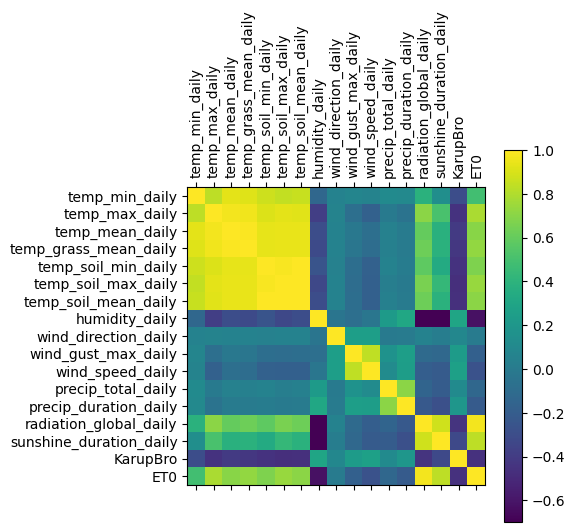

In [49]:
import matplotlib.pyplot as plt

# Correlation matrix
corr = merged_df.corr()
plt.figure(figsize=(12, 12))
plt.matshow(corr, fignum=2)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

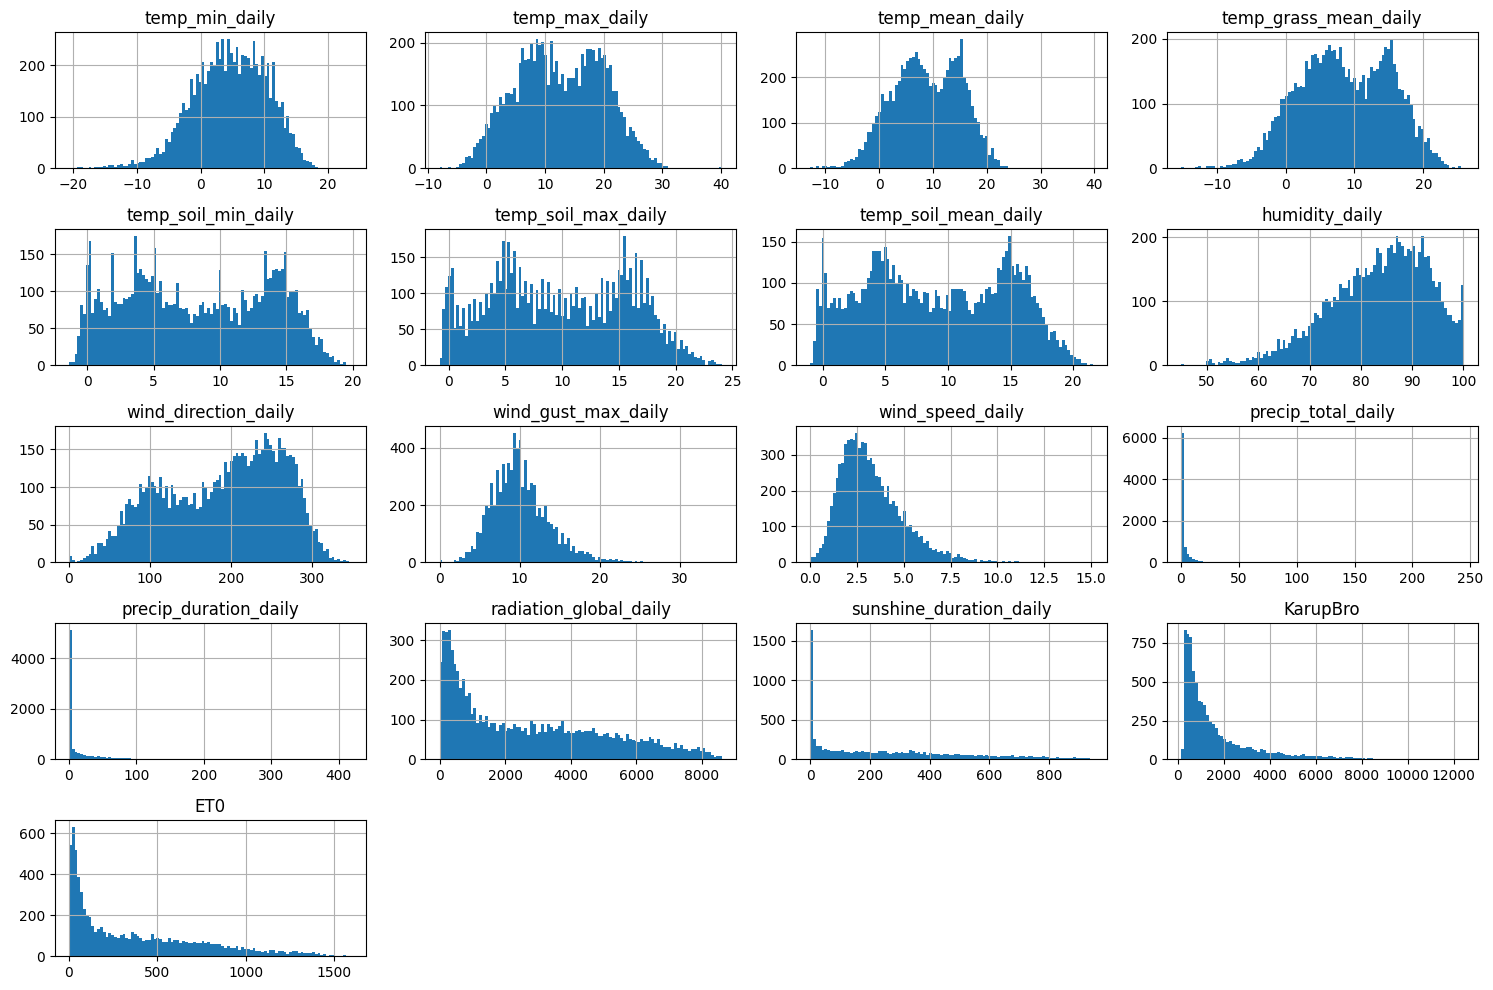

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
merged_df.hist(bins=100,figsize=(15, 10))
plt.tight_layout()
plt.show()


In [51]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# def filter_outliers_and_ffill(df, factor):
#     """
#     For each numeric column in the dataframe, this function:
#       1. Computes the IQR and sets values outside [Q1 - factor*IQR, Q3 + factor*IQR] to NaN.
#       2. Imputes missing values using forward fill.
#       3. Prints out the number of outliers overwritten for each column.
      
#     Parameters:
#         df (pd.DataFrame): The input dataframe.
#         factor (float): The multiplier for the IQR to determine outlier thresholds.
        
#     Returns:
#         pd.DataFrame: The dataframe with outliers filtered and imputed.
#     """
#     df_clean = df.copy()
#     numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
#     outlier_counts = {}

#     for col in numeric_cols:
#         Q1 = df_clean[col].quantile(0.25)
#         Q3 = df_clean[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - factor * IQR
#         upper_bound = Q3 + factor * IQR
        
#         # Create a boolean mask for outliers
#         is_outlier = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
#         count_outliers = is_outlier.sum()
#         outlier_counts[col] = count_outliers
        
#         # Set outliers to NaN
#         df_clean.loc[is_outlier, col] = np.nan
        
#         # Impute missing values using forward fill
#         df_clean[col] = df_clean[col].ffill()

#     # Print the outlier counts for each numeric column
#     print("Outlier counts overwritten per column:")
#     for col, count in outlier_counts.items():
#         print(f"{col}: {count}")
    
#     return df_clean

# # Apply the function to the merged dataset
# filter_outliers_and_ffill(merged_df, factor=20)

In [52]:
merged_df.to_csv("data_cleaned_and_interpolated.csv")